# Pre-requisites to creating models

In [1]:
### All imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import

## Data manipulation

### Get data

In [2]:
### Setup dataset viarables and methods for data import
import os
current_dir = os.getcwd()
data_dir = os.path.join(os.path.dirname(current_dir), "datasets", "plain_text_wikipedia", "AllCombined.txt")  # Path to all data
colab_path = "/content/datasets/plain_text_wikipedia/AllCombined.txt"

def get_lines(file_path):
    """
    Args:
        file_path: path to file (.txt file only)
    Returns:
        all the lines found in given file
    """
    with open(file_path, "r") as f:
        return f.readlines()

In [3]:
### Importing and storing the data into a variable
# all_data = get_lines(colab_path)
all_data = get_lines(data_dir)
print(f"Random line from the dataset:\n{all_data[60]}")  # Fixed position to 60 | many times the line is "\n"
print(f"Number of lines: {len(all_data)}")

Random line from the dataset:
Some people say that art is a product or item that is made with the intention of stimulating the human senses as well as the human mind, spirit and soul. An artwork is normally judged by how much impact it has on people, the number of people who can relate to it, and how much they appreciate it. Some people also get inspired.

Number of lines: 2052699


### Getting the data ready

#### Create a df for the lines

In [4]:
### Store data in a dataframe
all_data_df = pd.DataFrame(data=all_data, columns=["text"])  # Create df
all_data_df["word_count"] = all_data_df["text"].apply(lambda x: len(x.split()))  # Get word counts per line
all_data_df.head()

text  word_count
0                                                 \n           0
1                                            April\n           1
2                                                 \n           0
3  April (Apr.) is the fourth month of the year i...          31
4                                                 \n           0

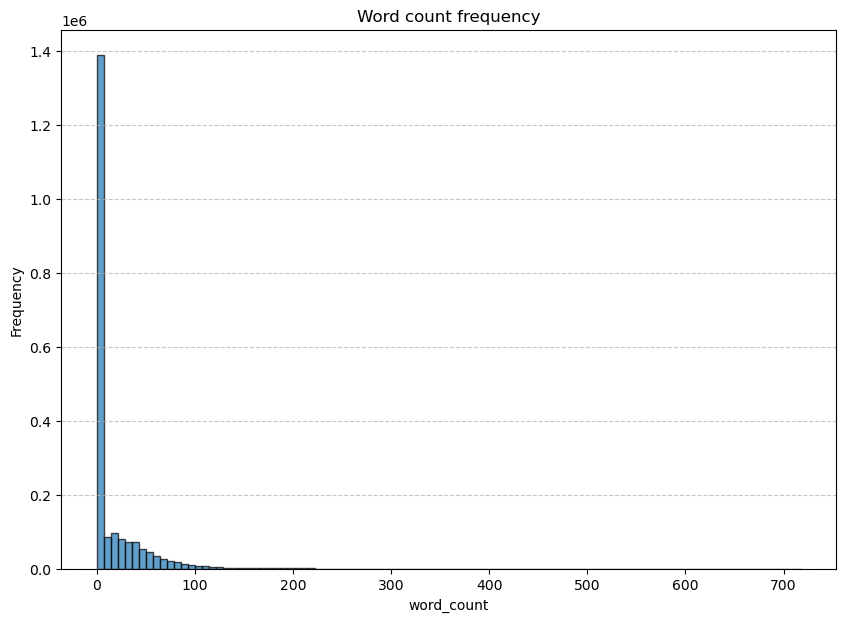

In [5]:
### Plot a histogram w/word_count
def plot_word_count(df: pd.DataFrame):
    """
    Plots a histogram wrt the word_count col in df.

    Args:
        df: DataFrame instance with "word_count" col
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 7))
    plt.hist(df["word_count"], bins=100, edgecolor='black', alpha=0.7,)
    plt.title("Word count frequency")
    plt.xlabel("word_count")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show();

plot_word_count(all_data_df)

There are many lines that have word_count = 0.\
All of these lines have the string "\n".\
We will be removing most of these lines, by keeping the lines with word_count = 0 when the next line has a non-zero word_count.\
<br>
We are keeping some empty lines, since the model will have to learn when to add an extra/empty line to seperate text outputs.

#### Filtering new-lines

In [6]:
def filter_empty_lines(df: pd.DataFrame):
    """
    Filters out most of the lines with an empty line in the df.
    Keeps all the empty lines if next line is non-empty.

    Args:
        df: DataFrame instance with the "line" and "word_count" columns
    Returns:
        Filtered df.
    """
    filtered_idx = []
    prev_non_zero = False
    len_df = len(df)

    for i in range(len_df):
        if df.loc[i, "word_count"] == 0:
            if not prev_non_zero and i+1<len_df and df.loc[i+1, "word_count"] > 0:
                filtered_idx.append(i)
            prev_non_zero = False
        else:
            filtered_idx.append(i)
            prev_non_zero = True
        
    return df.loc[filtered_idx]

def filter_empty_lines_for_paragraphs(df):
    """
    Removes unnecessary empty lines (word_count == 0).
    While preserving those between paragraphs (separating sequences of non-zero word count lines).

    Args:
        df: DataFrame with a 'word_count' column.

    Returns:
        Filtered df.
    """
    filtered_indices = []
    len_df = len(df)
    
    for i in range(len_df):
        if df.loc[i, 'word_count'] == 0:
            if (i > 0 and df.loc[i - 1, 'word_count'] > 0) and \
               (i + 1 < len_df and df.loc[i + 1, 'word_count'] > 0):
                filtered_indices.append(i)
        else:
            filtered_indices.append(i)
    
    return df.loc[filtered_indices].reset_index(drop=True)


In [7]:
#all_data_df_filtered = filter_empty_lines(all_data_df)
all_data_df_filtered = filter_empty_lines_for_paragraphs(all_data_df)
all_data_df_filtered.head(10)

text  word_count
0                                            April\n           1
1                                                 \n           0
2  April (Apr.) is the fourth month of the year i...          31
3                                                 \n           0
4  April always begins on the same day of the wee...          30
5                                                 \n           0
6  April comes between March and May, making it t...          40
7                                                 \n           0
8  April begins on the same day of the week as Ju...          51
9                                                 \n           0

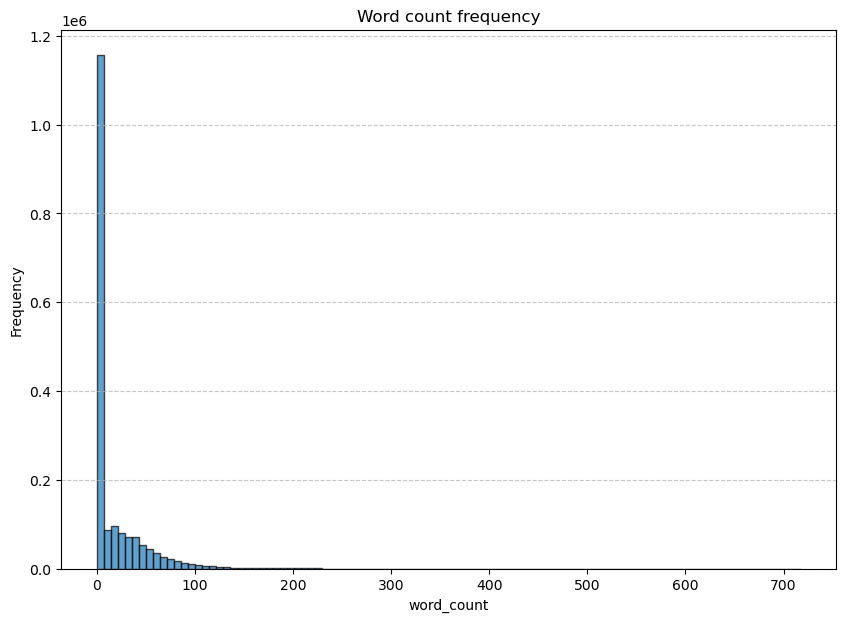

In [8]:
plot_word_count(all_data_df_filtered)

In [9]:
all_data_df_filtered[all_data_df_filtered["word_count"] > 600]

text  word_count
340380   In English culture, the Phoenix is ​​a mythica...         659
340410   Phoenix Short Story by Sylvia Town Sand Warner...         718
704121   Hershel tells Rick and his group that they hav...         636
1214309  Contreras first joined the UDP in 1997 when he...         654
1229308  Willis Seward Keith has graduated Princeton Un...         646
1410423  Hayainu's mother had died when Hayainu was a y...         679
1487861  Once there lived a widowed lady with her three...         647
1559111  On a Swedish country farm, a cat gives birth t...         611
1804461  In Chuacers The Canterbury Tales the 3rd Tale ...         625

In [10]:
all_data_df_filtered.sort_values(by="word_count", ascending=True, inplace=False)

text  word_count
910749                                                  \n           0
578780                                                  \n           0
1201032                                                 \n           0
578782                                                  \n           0
1201029                                                 \n           0
...                                                    ...         ...
1487861  Once there lived a widowed lady with her three...         647
1214309  Contreras first joined the UDP in 1997 when he...         654
340380   In English culture, the Phoenix is ​​a mythica...         659
1410423  Hayainu's mother had died when Hayainu was a y...         679
340410   Phoenix Short Story by Sylvia Town Sand Warner...         718

[1821500 rows x 2 columns]

In [11]:
len_all_data = len(all_data_df)
len_new_line_filtered = len(all_data_df_filtered)
print(f"Number of lines filtered (deleted): {len_all_data - len_new_line_filtered}")

Number of lines filtered (deleted): 231199


#### General preprocessing

Go to `scripts/english_lang_preprocessing.py` for the code.\
Go to `datasets/preprocessing/english_lang.txt` for the output of the above script.
<br></br>
***Note***: running this code as a .py script, since multiprocessing.Pool needs to be defined at the top of the file and may not work well in a jupyter env. sooo... yeah.

In [55]:
### Saving the current dataset as a .txt file
# Get path
from pathlib import Path
current_dir = Path(current_dir)
save_dir = current_dir.parent / "datasets" / "preprocessing"

# Create dir if not already
os.makedirs(save_dir, exist_ok=True)

# Save to path
all_data_df_filtered.to_csv(save_dir / "empty_lines_filtered.csv", encoding="utf-8")#, index=False)

In [36]:
### Language detection
from langdetect import detect, LangDetectException
from multiprocessing import Pool
import numpy as np
import re

def is_valid_line(line: str) -> bool:
    """
    Quickly checks if the line is valid without detecting the language.

    Args:
        line: line to check on
    Returns:
        True if line is valid
        False if otherwise
        None if more processing is requeried
    """
    line = line.strip()
    if not line:
        return False
    if re.fullmatch(r"[\d\s\W]+", line):
        return True
    return None

def detect_line(line: str) -> bool:
    """
    Detects if a line contains only English words, keeping numerical data and symbols.

    Args:
        line: single line to check
    Returns:
        bool, True if line belongs to english, else False
    """ 
    if (result := is_valid_line(line)) is not None:
        return result
    try:
        return detect(line) == "en"
    except LangDetectException as e:
        print(f"[ERROR] Unable to detect language for line:\n'{line}'\nError: {e}\n")
        return False
    except Exception as e:
        print(f"[ERROR] Unexpected error for line:\n'{line}'\nError: {e}\n")
        return False

def process_chunk(chunk):
    """
    Process a chunk of the DataFrame for English lines
    """
    return chunk[chunk["text"].apply(detect_line)]

In [ ]:
### Get all valid lines (using multiprocessing)
num_chunks = 10
chunks = np.array_split(all_data_df_filtered, num_chunks)

with Pool(processes=num_chunks) as pool:
    results = pool.map(process_chunk, chunks)

english_data_df = pd.concat(results, ignore_index=True)

In [33]:
### Add all the lines that are in english

# Get all the valid rows
rows_to_append = []
for i in range(len_new_line_filtered):
    row = all_data_df_filtered.loc[i]
    if detect_line(row["text"]):
        rows_to_append.append(i)


# New df with english data
english_data_df = pd.DataFrame(columns=["text", "word_count"])
english_data_df = pd.concat(english_data_df, pd.DataFrame(rows_to_append))

# Verify the output
print(len(english_data_df))
english_data_df.head()

[ERROR] Unable to detect language for line:
'Armenian alphabet: Ա, Բ, Գ, Դ, Ե, Զ, Է, Ը, Թ, Ժ, Ի, Լ, Խ, Ծ, Կ, Հ, Ձ, Ղ, Ճ, Մ, Յ, Ն, Շ, Ո, Չ, Պ, Ջ, Ռ, Ս, Վ, Տ, Ր, Ց, Ւ, Փ, Ք, Օ, Ֆ.'
Error: No features in text.

[ERROR] Unable to detect language for line:
'Hangul: ㄱ ㄲ ㄴ ㄷ ㄸ ㄹ ㅁ ㅂ ㅃ ㅅ ㅆ ㅇ ㅈ ㅉ ㅊ ㅋ ㅌ ㅍ ㅎ ㅏ ㅐ ㅑ ㅒ ㅓ ㅔ ㅕ ㅖ ㅗ ㅘ ㅙ ㅚ ㅛ ㅜ ㅝ ㅞ ㅟ ㅠ ㅡ ㅢ ㅣ'
Error: No features in text.

[ERROR] Unable to detect language for line:
'Bopomofo: ㄅ ㄆ ㄇ ㄈ ㄉ ㄊ ㄋ ㄌ ㄍ ㄎ ㄏ ㄐ ㄑ ㄒ ㄓ ㄔ ㄕ ㄖ ㄗ ㄘ ㄙ ㄚ ㄛ ㄜ ㄝ ㄞ ㄟ ㄠ ㄡ ㄢ ㄣ ㄤ ㄥ ㄦ ㄧ ㄨ ㄩ ㄭ'
Error: No features in text.

[ERROR] Unable to detect language for line:
'Ogham:   ᚁ ᚂ ᚃ ᚄ ᚅ ᚆ ᚇ ᚈ ᚉ ᚊ ᚋ ᚌ ᚍ ᚎ ᚏ ᚐ ᚑ ᚒ ᚓ ᚔ ᚕ ᚖ ᚗ ᚘ ᚙ ᚚ ᚛ ᚜'
Error: No features in text.

[ERROR] Unable to detect language for line:
'Ethiopic ሀ ለ ሐ መ ሠ ረ ሰ ቀ በ ተ ኀ ነ አ ከ ወ ዐ ዘ የ ደ ገ ጠ ጰ ጸ ፀ ፈ ፐ'
Error: No features in text.



KeyboardInterrupt: 

In [34]:
len(rows_to_append)

22779

#### Create df for words

In [12]:
### Create a new "words" df
def is_english_word(word: str):
    """
    Returns True, if 'word' is fron the english language.
    Auto strips the puntuation, to extract the word only.
    """
    import re
    import string
    word = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', word)
    return word.strip().lower() in english_vocab

In [16]:
for row in all_data_df_filtered.items():
    print(row[1][10])

In common years, April starts on the same day of the week as October of the previous year, and in leap years, May of the previous year. In common years, April finishes on the same day of the week as July of the previous year, and in leap years, February and October of the previous year. In common years immediately after other common years, April starts on the same day of the week as January of the previous year, and in leap years and years immediately after that, April finishes on the same day of the week as January of the previous year.

103


In [4]:
### Cleaning the data
# Following changes
# lower-case, stopwords, 
import re
def clean_data(text):
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [5]:
### Filtering all_data
all_data_filtered = [clean_data(line) for line in all_data if clean_data(line)]

In [6]:
### Verify filteration
len(all_data), len(all_data_filtered)

(2052699, 965517)

In [7]:
def get_words(text):
    """
    Returns all unique words found in text
    """
    words = text.split()
    return words

In [8]:
all_data_filtered_words = []
for line in all_data_filtered:
    all_data_filtered_words.extend(get_words(line))
all_data_filtered_words = sorted(set(all_data_filtered_words))
all_data_filtered_words[:5]

['A', 'AA', 'AAA', 'AAAA', 'AAAAA']

In [9]:
### Finding all irregular words and their sentences
import re
import enchant
from nltk.tokenize import sent_tokenize
english_dict = enchant.Dict("en_US")
def is_english(word):
    """
    Checks if a words is from the english dict
    """
    return english_dict.check(word)

import nltk
nltk.download("punkt")
def get_sentences_wth_irregular_words(text, issegular_words):
    sentences = sent_tokenize(text)
    sentences_with_irregular_words = []
    for sentence in sentences:
        if any(irregular_word in sentence for irregular_word in irregular_words):
            sentences_with_irregular_words.append(sentence)
    return sentences_with_irregular_words

ImportError: The 'enchant' C library was not found and maybe needs to be installed.
See  https://pyenchant.github.io/pyenchant/install.html
for details


In [ ]:
irregular_words = [word for word in all_data_filtered_words if not is_english(word)]

### Split and validate data

In [32]:
### Split the data into train-test-validation splits
def get_splits(target_data,
               train_size: float = 0.7,
               test_size: float = 0.15,
               validation_size: float = 0.15,
               shuffle: bool = True,
               seed: int = 42):
    """
    Args:
        target_data: dataset to split on
        train_size: size of the train dataset
        test_size: size of the test dataset
        validation_size: size of the validation dataset
        shuffle: shuffle the target_dataset before spliting
    Returns:
        train_split, test_split, validation_split
    """
    import random

    # Setup
    _sum = train_size+test_size+validation_size
    assert _sum == 1, f"Sum of all sizes must be 1 got {sum}"
    random.seed(seed)
    if shuffle:
        random.shuffle(target_data)

    # Get split idx's
    total_length = len(target_data)
    train_end_idx = int(total_length * train_size)
    test_end_idx = train_end_idx + int(total_length * test_size) + 1
    validation_end_idx = test_end_idx + int(total_length * validation_size) + 1

    # Split the data into train-test-validation
    train_split = target_data[:train_end_idx]
    test_split = target_data[train_end_idx:test_end_idx]
    validation_split = target_data[test_end_idx:validation_end_idx]

    return train_split, test_split, validation_split

def validate_splits(train_data, test_data, validation_data, leak_ok: bool = False):
    """
    Args:
        leak_ok: set to False to check for data-leakage, set to True otherwise
        *All other arguments have same meaning as their name
    """
    _train_set = set(train_data)
    _test_set = set(test_data)
    _validation_set = set(validation_data)
    overlap_train_test = _train_set.intersection(_test_set)
    overlap_train_validation = _train_set.intersection(_validation_set)
    overlap_validation_test = _validation_set.intersection(_test_set)
    print(f"Overlap train-test: {len(overlap_train_test)}")
    print(f"Overlap train-validation: {len(overlap_train_validation)}")
    print(f"Overlap validation-test: {len(overlap_validation_test)}")
    _sum = len(overlap_train_test)+len(overlap_train_validation)+len(overlap_validation_test)
    if not leak_ok:
        assert _sum == 0, f"There exists a data-leakage. Found '{_sum}' samples overlaping."
    return overlap_train_test, overlap_train_validation, overlap_validation_test

In [33]:
# Get splits
train_data, test_data, validation_data = get_splits(
    target_data=all_data_filtered,
    # Leaving all as default
)

# Get some info about the splits
_sum = len(train_data)+len(test_data)+len(validation_data)  # sum of splits
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Validation samples: {len(validation_data)}")
print(f"{_sum==len(all_data)}")
# Check for data leakages
overlaps = validate_splits(
    train_data=train_data,
    test_data=test_data,
    validation_data=validation_data,
    leak_ok=True, # We may have some leaks atm from chars like "\n"
)

Train samples: 675861
Test samples: 144828
Validation samples: 144828
False
Overlap train-test: 2715
Overlap train-validation: 2714
Overlap validation-test: 1205


## Model 'preprocessing'

Creating the **Tokenizer** and **Text-dataset** classes. \
These will be used to create PyTorch friendly datasets.

In [34]:
### Check the data split's lengths
len(train_data), len(test_data), len(validation_data)

(675861, 144828, 144828)

In [35]:
### Get vocab
# Create a general purpose tokenizer
class Tokenizer():
    def __init__(self, token_size):
        """
        Creates an instance of a tokenizer.
        You can use this object to convert raw data into tokens.

        Args:
            token_size: size of each token
        """
        self.token_size = token_size
        self._vocab = None
        self._stoi = None
        self._itos = None

    def _preprocess(self,
                    text: list,
                    strip_punctuation = False) -> list:
        """
        Preprocesses a string to handle punctuation and normalize tokens.

        Args:
            text: a string to preprocess
            strip_punctuation: whether to strip punctuation during preprocessing
        Returns:
            Preprocessed string
        """
        import re
        import string

        # Strip punctuation if required
        if strip_punctuation:
            text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        else:
            # Add spaces around punctuation
            text = re.sub(r"([.,!?;:])", r" \1 ", text)
            text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        return text

    def _token_split(self,
                     text: str,
                     strip_punctuation) -> list:
        """
        Tokenize a single input string into chunks of token_size words.

        Args:
            text: a string to tokenize
            strip_punctuation: whether to strip punctuation during preprocessing
        Returns:
            A list, where each entry has 'token_size' number of words
        """
        tokens = []
        # Preprocess the string
        text = self._preprocess(text=text, strip_punctuation=strip_punctuation)
        words = text.split()
        for i in range(0, len(words), self.token_size):
            tokens.append(" ".join(words[i:i + self.token_size]))

        return tokens

    def build_vocab(self,
                   data: list,
                   strip_punctuation: bool = False):
        """
        Produces a vocab list, on the given tokens.

        Args:
            data: list of sentences to build the vocab on
            strip_puntuation: where to srip punctuation during preprocessing
        Returns:
             vocab: list of unique tokens
             stoi: dict mapping strings to indices
             itos: dict mapping indices to strings
        """
        tokens = []
        for sentence in data:
            tokens.extend(self._token_split(sentence, strip_punctuation=strip_punctuation))
        self._vocab = sorted(set(tokens))
        self._stoi = {token: idx for idx, token in enumerate(self._vocab)}
        self._itos = {idx: token for token, idx in self._stoi.items()}

        return self._vocab, self._stoi, self._itos

    def tokenize_string(self,
                 text: str,
                 strip_punctuation = False) -> list:
        """
        Tokenizes the given string into tokens based on the prebuilt vocab.

        Args:
            text: string to tokenize
            strip_puntuation: where to srip punctuation during preprocessing
        Returns:
            List of tokens converted to indices
        """
        assert self._stoi is not None, f"Vocab is not built yet. Call .build_vocab first."
        tokens = self._token_split(text=text, strip_punctuation=strip_punctuation)
        token_indices = [self._stoi[token] for token in tokens if token in self._stoi]

        return token_indices

In [36]:
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,
                 data,
                 tokenizer,
                 strip_punctuation = False,
                 max_len = None):
        """
        Custom dataset for tokenized text.
        Builds a tokenized dataset on provided data, using the specified tokenizer.

        Args:
            data: list of sentences
            tokenizer: instance of the Tokenizer class
            strip_punctuation: whether to strip punctuation during preprocessing.
            max_len: optional, maximum length of tokenized sequences (for padding).
        """
        self.data = data
        self.tokenizer = tokenizer
        self.strip_punctuation = strip_punctuation
        self.max_len = max_len
        self.tokenized_data = [self.tokenizer.tokenize_string(line, strip_punctuation) for line in self.data]
        if self.max_len:
            self.tokenized_data = [tokens[:self.max_len] for tokens in self.tokenized_data] # Truncate

    def __len__(self):
        """
        Number of samples in "data"
        """
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        """
        Returns a tokenized sample from "data" at "idx".

        Args:
            idx: index of sample to retrieve
        Returns:
            Sample at "idx", tokenized.
        """
        tokens = self.tokenized_data[idx]
        tokens_tensor = torch.tensor(tokens, dtype=torch.long)
        return tokens_tensor

In [37]:
### Tokenizer hyperparams
TOKEN_SIZE = 1
STRIP_PUNCTUATION = False

# Tokenizer instance (and setup)
tokenizer = Tokenizer(TOKEN_SIZE)
vocab, stoi, itos = tokenizer.build_vocab(
    data=train_data,
    strip_punctuation=STRIP_PUNCTUATION,
)

In [38]:
# Sample text data/strings
sample_data = [
    "This is the first sentence.",
    "Another example, with punctuation!",
    "Let's see if this works well."
]

"""
# Tokenize sample_data
sample_data_tokenized = tokenizer.tokenize_string(text=sample_data[0])
print(sample_data_tokenized)
for i in sample_data_tokenized:
    print(itos[i])
"""

dataset = TextDataset(data=sample_data, tokenizer=tokenizer, strip_punctuation=False, max_len=None)

In [39]:
dataset.__len__()

3

In [40]:
dataset.__getitem__(1)

tensor([ 13121, 356050, 443771, 408348])

In [41]:
for i in dataset.__getitem__(1):
    print(itos[i.item()])

Another
example
with
punctuation


In [42]:
max(itos.keys())

445779

In [43]:
itos.values()

dict_values(['A', 'AA', 'AAA', 'AAAA', 'AAAAA', 'AAAAABBBB', 'AAAAAclass', 'AAABAB', 'AAABB', 'AAAGTCTGAC', 'AAAS', 'AAAs', 'AAB', 'AABAB', 'AABB', 'AABBA', 'AABBB', 'AABBCC', 'AAC', 'AACE', 'AACI', 'AACII', 'AACMPMAMB', 'AACR', 'AACS', 'AACSB', 'AACTA', 'AACencoded', 'AAD', 'AADA', 'AADCVH', 'AADCVHZI', 'AADGT', 'AADHAR', 'AAE', 'AAEDI', 'AAEE', 'AAF', 'AAFC', 'AAGCCTA', 'AAGCTTA', 'AAHL', 'AAIB', 'AAK', 'AAL', 'AALC', 'AAM', 'AAMI', 'AAN', 'AAP', 'AAPS', 'AAPs', 'AAR', 'AARP', 'AAS', 'AASHTO', 'AASimpson', 'AAT', 'AAU', 'AAVE', 'AAW', 'AAZ', 'AAguns', 'AAs', 'AB', 'ABA', 'ABAAB', 'ABAB', 'ABABA', 'ABABAB', 'ABABABCC', 'ABABB', 'ABABBBCBCC', 'ABABBCC', 'ABACADA', 'ABACADAEAFA', 'ABANBA', 'ABAP', 'ABAs', 'ABB', 'ABBA', 'ABBAA', 'ABBAABAAB', 'ABBAB', 'ABBAs', 'ABBBA', 'ABBBBBBK', 'ABC', 'ABCCBA', 'ABCCBS', 'ABCD', 'ABCDEF', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'ABCDEFGHJK', 'ABCDEFU', 'ABCFamilySeries', 'ABCFox', 'ABCG', 'ABCKIDS', 'ABCL', 'ABCNBC', 'ABCNetflix', 'ABCParamount', 'ABCS', 'ABCTV